In [1]:
# Smart Building Energy Optimization: XGBoost & LSTM with Appliances Energy Prediction Dataset

## 1. Import Libraries
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

# Then import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Note: you may need to restart the kernel to use updated packages.


In [1]:
## 2. Load and Prepare Dataset
# Load Appliances Energy Prediction Dataset (replace with actual local path or URL download)
import pandas as pd 
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
df = pd.read_csv(url)


# Preview data
print(df.head())

                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility

In [2]:
## 3. Data Preprocessing

# Import pandas first
import pandas as pd  # Added import statement for pandas
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Drop timestamp for modeling, parse it separately for time series if needed
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Use all features except Appliances as X, Appliances as y
X = df.drop(columns=['Appliances'])
y = df['Appliances']

# Scale features and target
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [4]:
# Import the train_test_split function from sklearn
from sklearn.model_selection import train_test_split

## 4. Train-Test Split: For XGBoost (Random split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [6]:
## 5. XGBoost Model with Hyperparameter Tuning

# Import the necessary libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train.ravel())

print("Best XGBoost params:", grid_search.best_params_)

best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Test MSE: {mse_xgb:.6f}, R2: {r2_xgb:.3f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.7}
XGBoost Test MSE: 0.003978, R2: 0.545


In [8]:
## 6. Prepare Data for LSTM (Time Series Modeling)

# Import NumPy library
import numpy as np  # Added import statement for NumPy

# Function to create sequences for LSTM
def create_sequences(X_data, y_data, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        Xs.append(X_data[i:(i + time_steps)])
        ys.append(y_data[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, time_steps)

# Train-test split for time series (chronological)
split_idx = int(X_lstm.shape[0] * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [10]:
## 7. Build and Train LSTM Model

# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_lstm, y_train_lstm, 
                    epochs=50, 
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0133 - val_loss: 0.0081
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0085 - val_loss: 0.0108
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0081 - val_loss: 0.0098
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0078 - val_loss: 0.0108
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0076 - val_loss: 0.0109
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0073 - val_loss: 0.0105
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0071 - val_loss: 0.0094
Epoch 9/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0069 - val_loss: 0.0091
Epoch 10/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0066 - val_loss: 0.0108
Epoch 11/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0066 - val_loss: 0.0126


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
LSTM Test MSE: 0.011154, R2: -0.555


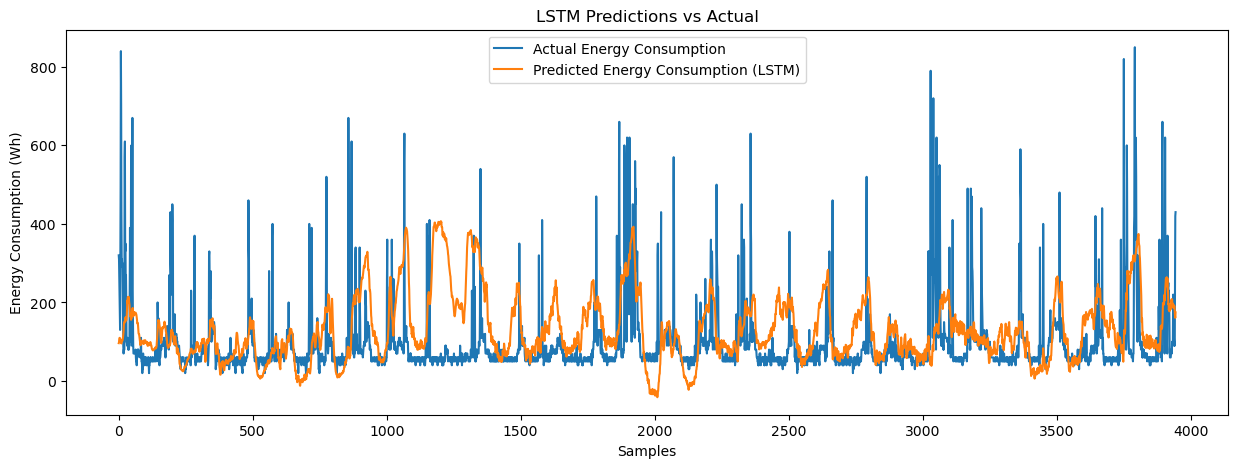

In [12]:
## 8. Evaluate LSTM Model
import matplotlib.pyplot as plt  # Add this import statement

y_pred_lstm = model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"LSTM Test MSE: {mse_lstm:.6f}, R2: {r2_lstm:.3f}")

# Inverse scale predictions for visualization
y_test_inv = scaler_y.inverse_transform(y_test_lstm)
y_pred_inv = scaler_y.inverse_transform(y_pred_lstm)

plt.figure(figsize=(15,5))
plt.plot(y_test_inv, label='Actual Energy Consumption')
plt.plot(y_pred_inv, label='Predicted Energy Consumption (LSTM)')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.show()